### Tercera propuesta

Se filtran los atributos, dejando aquellos que representan cómo suena una canción.

In [ ]:
X=df[['danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']]
X.head()

,danceability,loudness,acousticness,instrumentalness,valence,energy
0,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110
1,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240
2,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112
3,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736
4,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375


###Agrupaciones según etiqueta

En primer lugar, se pueden visualizar los 7 clusters que generaría un modelo perfecto que agrupa canciones según sus géneros, con la técnica PCA. Luego, al aplicar los distintos modelos de clustering sobre la data no etiquetada, se esperaría obtener una distribución similar a la mostrada a continuación.

In [ ]:
dicc={"pop":0,"country":1,"blues":2,"jazz":3,"reggae":4,"rock":5,"hip hop":6}
values=df["genre"].copy().to_numpy()
for i in range (0, len(values)):
  values[i] = dicc[values[i]]

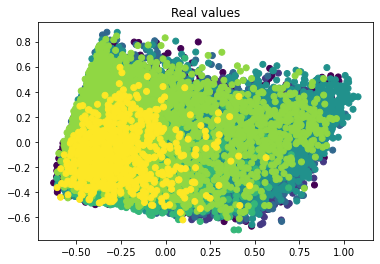

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2).fit(X)
new_X = pca.transform(X) 

plt.scatter(new_X[:, 0], new_X[:, 1], c=values)
plt.title("Real values")
plt.show()

###K-means

Como se sugirió en la retroalimentación, sería interesante primero estudiar si realmente la cantidad de clusters debiese ser igual a la cantidad de géneros, pues podría eventualmente existir otra agrupación natural de las canciones. Para ello, se utiliza el método del codo. 

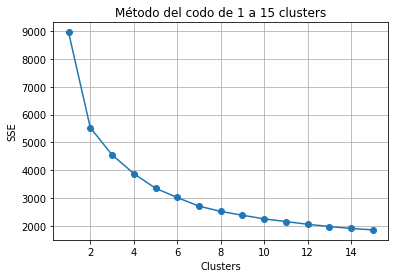

In [ ]:
from sklearn.cluster import KMeans

sse = []
clusters = list(range(1, 16))
for k in clusters:
    kmeans = KMeans(n_clusters=k).fit(X)
    sse.append(kmeans.inertia_)

plt.plot(clusters, sse, marker="o")
plt.title("Método del codo de 1 a 15 clusters")
plt.xlabel("Clusters")
plt.ylabel("SSE")
plt.grid(True)
plt.show()

Si bien el codo obtenido no es muy distintivo, podría sin problemas considerarse K=7 el punto de inflexión. Por lo tanto, este resultado coincide en que se deben encontrar 7 agrupaciones de canciones. Dado lo anterior, se ejecuta K-means con K=7.

In [ ]:
kmeans1 = KMeans(n_clusters=7, n_init=10, max_iter=300)
kmeans1.fit(X)
kmeans1.labels_

array([3, 5, 5, ..., 6, 6, 2], dtype=int32)

Se obtiene la asignación de cada canción según el modelo de clustering.

In [ ]:
df_labeled = df['genre'].copy().to_frame()
df_labeled['cluster_id'] = kmeans1.labels_
df_labeled

,genre,cluster_id
0,pop,3
1,pop,5
2,pop,5
3,pop,6
4,pop,5
...,...,...
28367,hip hop,6
28368,hip hop,6
28369,hip hop,6
28370,hip hop,6


A continuación se muestra la proporción de asignación de canciones a cada cluster, por cada género.

In [ ]:
for genre in ['blues', 'country', 'hip hop', 'jazz', 'pop', 'reggae', 'rock']:
  df_genre = df_labeled[df_labeled['genre'] == genre] # Filtrar por género
  df_grouped = df_genre.groupby(['cluster_id']) # Agrupar por cluster
  print('Cantidad de canciones en ' + genre + ': ' + str(len(df_genre)))
  print(round(df_grouped.count()/len(df_genre), 3))
  print('\n')

Cantidad de canciones en blues: 4604
            genre
cluster_id       
0           0.199
1           0.075
2           0.124
3           0.020
4           0.208
5           0.165
6           0.209


Cantidad de canciones en country: 5445
            genre
cluster_id       
0           0.229
1           0.005
2           0.194
3           0.009
4           0.086
5           0.265
6           0.213


Cantidad de canciones en hip hop: 904
            genre
cluster_id       
0           0.069
1           0.013
2           0.143
3           0.002
4           0.153
5           0.003
6           0.617


Cantidad de canciones en jazz: 3845
            genre
cluster_id       
0           0.141
1           0.132
2           0.098
3           0.128
4           0.078
5           0.270
6           0.153


Cantidad de canciones en pop: 7042
            genre
cluster_id       
0           0.138
1           0.034
2           0.173
3           0.011
4           0.205
5           0.153
6           0.2

De lo anterior se desprende lo siguiente:

*   Las canciones de blues, hip hop, pop y reggae tienden a irse al mismo cluster.
*   Las canciones de country y jazz tienden irse a otro cluster.
*   Las canciones de rock tienden a irse a un cluster aparte.

Claramente los resultados anteriores no son definitivos, pues las distribuciones no tienen una preferencia concreta por un cluster y hay clusters con muy pocas canciones de todos los géneros. Recordando que la probabilidad de asignación aleatoria a un género dado es 0,14, se podría decir que algunas agrupaciones sí son sensatas.



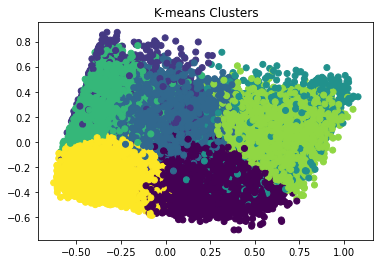

In [ ]:
plt.scatter(new_X[:, 0], new_X[:, 1], c=kmeans1.labels_)
plt.title("K-means Clusters")
plt.show()

Finalmente, si se grafican los clusters y comparan con la distribución original es claro que los clusters generados no replican la asignación manual de géneros.

Dado que el resultado anterior no es del todo satisfactorio, se podría estudiar si canciones de solamente dos géneros son separables. Se pueden considerar solamente jazz y rock, pues son géneros que son intuitivamente distintos en cómo suenan, tendían a irse a clusters distintos en el modelo anterior y además tendían a no irse al cluster del otro, es decir, en el cluster asociado al rock no calzaron muchas canciones de jazz y viceversa.


In [ ]:
df_filtrado = df[(df['genre'] == 'jazz') | (df['genre'] == 'rock')].copy()
X_filtrado = df_filtrado[['danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']]
kmeansf = KMeans(n_clusters=2, n_init=10, max_iter=300)
kmeansf.fit(X_filtrado)
kmeansf.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [ ]:
df_labeled_filtrado = df_filtrado['genre'].copy().to_frame()
df_labeled_filtrado['cluster_id'] = kmeansf.labels_
df_labeled_filtrado

,genre,cluster_id
17091,jazz,1
17092,jazz,1
17093,jazz,1
17094,jazz,1
17095,jazz,1
...,...,...
27463,rock,0
27464,rock,0
27465,rock,0
27466,rock,0


In [ ]:
for genre in ['jazz', 'rock']:
  df_genre_filtrado = df_labeled_filtrado[df_labeled_filtrado['genre'] == genre] # Filtrar por género
  df_grouped_filtrado = df_genre_filtrado.groupby(['cluster_id']) # Agrupar por cluster
  print('Cantidad de canciones en ' + genre + ': ' + str(len(df_genre_filtrado)))
  print(round(df_grouped_filtrado.count()/len(df_genre_filtrado), 3))
  print('\n')

Cantidad de canciones en jazz: 3845
            genre
cluster_id       
0           0.444
1           0.556


Cantidad de canciones en rock: 4034
            genre
cluster_id       
0           0.814
1           0.186




Si se observa la asignación de clusters, se podría sin ambigüedad decir que hay un cluster que se puede asociar a canciones de jazz y que el otro cluster se puede asociar a las de rock. Sin embargo, la agrupación generada es tal que el cluster asociado al rock captura muchísimas de las canciones de rock (aproximadamente el 80%) y al mismo tiempo una gran cantidad de las de jazz (aproximadamente el 44%), mientras que el cluster asociado al jazz captura una gran cantidad de las de jazz y pocas de las de rock. Es decir, el cluster asociado al jazz es más selectivo para el género jazz que el cluster asociado al rock lo es para el género rock. Se concluye entonces que el modelo generado captura la diferencia que rock tiene del jazz, pero no muy bien la inferencia que se haría sobre una canción de jazz.


### DBSCAN

Para ejecutar el algoritmo DBSCAN, se deben escoger los parámetros min_samples y eps. El segundo parámetro se puede estimar a partir del primero con el método de la rodilla. Por lo tanto, se exploran distintos valores para min_samples y ejecuta DBSCAN para ver si la cantidad de clusters generada es razonable. Con un valor muy grande se obtenían muy pocos clusters y con un valor muy pequeño se obtenían muchísimos clusters. El valor intermedio escogido es entonces min_samples = 10. 

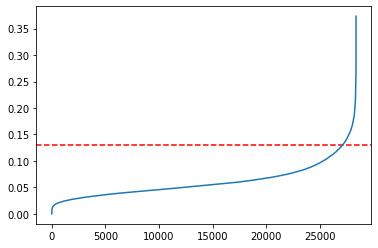

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

N = 10 #corresponde a 'min_samples'

nbrs = NearestNeighbors(n_neighbors=N).fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=0.13, color='r', linestyle='--') #Ajuste el valor para y
plt.plot(distances);

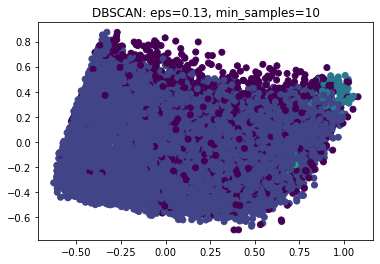

In [ ]:
from sklearn.cluster import DBSCAN

eps = 0.13
min_samples = 10

dbscan2 = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
plt.scatter(new_X[:,0], new_X[:,1], c=dbscan2.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={N}")
plt.show()

In [ ]:
np.unique(dbscan2.labels_)

array([-1,  0,  1,  2,  3,  4])

El problema es que este valor no representa una cantidad razonable con respecto a la distribución original de canciones entre los 7 géneros, y debiese ser un valor en el orden de las centenas o miles (un género con 10 canciones no es un género). Además, visualmente se observan muchísimos outliers, lo que no provee utilidad. Se concluye que quizás un método por densidad no es apropiado para este conjunto de datos debido a su dispersión en el espacio de atributos.

###Jerárquico

Para decidir el punto de corte en el clustering jerárquico de tipo aglomerativo, se genera el dendrogama correspondiente. Se corta en 20 para obtener 7 clusters.

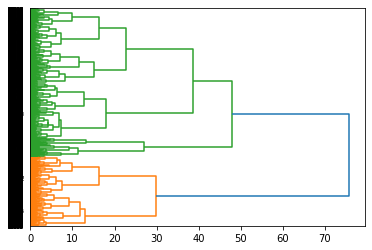

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, 'ward', metric='euclidean')
dn = dendrogram(Z, orientation='right')

In [ ]:
from sklearn.cluster import AgglomerativeClustering

complete_all2 = AgglomerativeClustering(linkage="ward", 
                                       affinity='euclidean', 
                                       n_clusters=None, 
                                       distance_threshold=20).fit(X)

Al graficar los clusters generados por el clustering aglomerativo, se obtiene nuevamente una distribución que no coincide con los valores reales.

In [ ]:
plt.scatter(new_X[:,0], new_X[:,1], c=complete_all2.labels_)
plt.title('Clustering aglomerativo')
plt.show()

Se concluye que los algoritmos de clustering son incapaces de replicar la asignación manual de géneros. En este proyecto solamente se evaluó de manera externa porque es lo que interesaba estudiar, pero sí es posible que existan agrupaciones naturales y estas eventualmente se podrían estudiar en otra oportunidad y ser evaluadas con otros métodos de validación interna como matriz de similitud o Silhouette. Lo anterior fundamenta el hecho de que quizás la forma de asociación manual de géneros (es decir, el proceso humano de considerar a varias canciones como similares y agruparlas en un género) tiene varios aspectos no matemáticos. Sería posible entonces que canciones que tienen país de origen similar o provienen de un mismo artista tiendan a agruparse en géneros similares cuando el sonido no sea similar. Otra posibilidad es que las canciones tienen una complejidad mucho más grande que solo los aspectos técnicos escogidos; por ejemplo, es posible que la presencia y reconocimiento de un instrumento en particular por un ser humano induzca a que una canción se clasifique de cierto género cuando hay varios otros aspectos que indican que sea otro género.

## 6. Conclusiones y planificación futura

En el escenario en que se contase con más tiempo para continuar el desarrollo de este proyecto, el curso de acción que se tomaría sería probar con otras combinaciones de atributos buscando correlaciones entre ellas. También se buscarían más datasets sobre este tema que puedan incluir atributos nuevos útiles, con el propósito de una exploración más a fondo con tal de complementar la información a estudiar. Además, en específico para el problema de clustering, sería interesante seguir estudiando los clusters generados con validación interna, pues en este proyecto solo se consideró si se replican las etiquetas conocidas y se podría estudiar qué tan buenas son las agrupaciones naturales de los datos, si las hay.

A modo de recomendaciones a futuras personas que deseasen abordar este problema, se sugiere indagar más en los atributos temáticos incluídos en la base de datos, los cuales describen los asuntos tratados en las letras de las canciones, por lo cual se puede encontrar en ellos una mejor descripción emocional de éstas. Algunos de estos atributos corresponden a "violence", "romance", "world/life", etc. Así, se puede ver cómo estos valores numéricos asociados a cada temática representan de qué se habla en las canciones y se puede identificar un vínculo emocional más claro. Además, se encuentra el atributo "topic", el cual muestra el tema principal tratado en cada canción, por lo que se podría estudiar qué tópicos son más abordados en cada género musical.

##7. Contribuciones de integrantes (Hito 3)
* Redacción de introducción:
* Exploración de datos:
* Redacción de preguntas y problemas:
* Desarrollo de primera propuesta experimental:
* Desarrollo de segunda propuesta experimental:
* Desarrollo de tercera propuesta experimental:
* Resultados preliminares:
* Redacción de conclusiones y planificación futura: Jules Fredes C.
* Diseño de diapositivas: Jules Fredes C.
* Edición y correción: Diego Carmona

